In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LayerNormalization, MultiHeadAttention, Conv2DTranspose, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define paths and image size
base_path = r'C:\Users\Sejal\Desktop\FOSS\archive\asl_dataset'
image_size = (128, 128)  # Resize images to this size

# Function to load images and labels
def load_images_from_folders(base_path, image_size):
    images = []
    labels = []
    for letter_folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, letter_folder)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                img = load_img(img_path, target_size=image_size)
                img = img_to_array(img) / 255.0  # Normalize images
                images.append(img)
                labels.append(letter_folder)
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_from_folders(base_path, image_size)

# Encode labels
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(labels)
label_sequences = tokenizer.texts_to_sequences(labels)
max_label_length = max(len(seq) for seq in label_sequences)
label_sequences = pad_sequences(label_sequences, maxlen=max_label_length)

model = build_transformer_model(vocab_size, text_dim, img_shape)
model.compile(optimizer='adam', loss='binary_crossentropy')

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(label_sequences, images, test_size=0.2, random_state=42)

# Build Transformer model
def build_transformer_model(vocab_size, text_dim, img_shape):
    text_input = Input(shape=(None,), name='text_input')
    text_embedding = Embedding(input_dim=vocab_size, output_dim=text_dim)(text_input)
    
    # Transformer Encoder
    transformer_block = MultiHeadAttention(num_heads=8, key_dim=text_dim)(text_embedding, text_embedding)
    transformer_block = tf.keras.layers.Add()([text_embedding, transformer_block])
    transformer_block = LayerNormalization()(transformer_block)
    
    # Image Decoder
    x = Dense(128 * 16 * 16, activation='relu')(transformer_block[:, 0, :])  # Output size 16x16
    x = Reshape((16, 16, 128))(x)
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)  # Output size 32x32
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)  # Output size 64x64
    img_output = Conv2DTranspose(img_shape[2], kernel_size=4, strides=2, padding='same', activation='sigmoid')(x)  # Output size 128x128

    model = Model(inputs=text_input, outputs=img_output)
    return model

# Example setup
vocab_size = len(tokenizer.word_index) + 1
text_dim = 256
img_shape = (128, 128, 3)  # Desired image size

model_2 = build_transformer_model(vocab_size, text_dim, img_shape)
model_2.compile(optimizer='adam', loss='binary_crossentropy')

# Training the model
def train_model(model, X_train, y_train, epochs=50, batch_size=8):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

train_model(model, X_train, y_train, epochs=50, batch_size=8)

# Generate images from text input
def generate_image_from_text(model, text_input):
    seq = tokenizer.texts_to_sequences([text_input])
    seq = pad_sequences(seq, maxlen=max_label_length)
    generated_image = model.predict(seq)
    generated_image = generated_image.squeeze()  # Remove batch dimension
    plt.imshow(generated_image)
    plt.axis('off')
    plt.show()

Epoch 1/50


c:\Users\Sejal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


202/202 ━━━━━━━━━━━━━━━━━━━━ 59s 258ms/step - loss: 0.3768 - val_loss: 0.3055
Epoch 2/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 52s 257ms/step - loss: 0.3022 - val_loss: 0.3024
Epoch 3/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 53s 263ms/step - loss: 0.2978 - val_loss: 0.3025
Epoch 4/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 48s 240ms/step - loss: 0.2967 - val_loss: 0.2957
Epoch 5/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 48s 238ms/step - loss: 0.2952 - val_loss: 0.2963
Epoch 6/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 48s 238ms/step - loss: 0.2969 - val_loss: 0.2961
Epoch 7/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 49s 241ms/step - loss: 0.2982 - val_loss: 0.2951
Epoch 8/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 49s 244ms/step - loss: 0.2906 - val_loss: 0.2957
Epoch 9/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 50s 250ms/step - loss: 0.2949 - val_loss: 0.2964
Epoch 10/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 81s 245ms/step - loss: 0.2940 - val_loss: 0.2949
Epoch 11/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 47s 230ms/step - loss: 0.2940 - val_loss: 0.2944
Epoch 12/50
202/202 ━━━━━━━━━━

In [24]:
# Example of generating an image for letter 'a'
generate_image_from_text(model_2, 'a')


NameError: name 'generate_image_from_text' is not defined

In [9]:
model_save_path = r'C:\Users\Sejal\Desktop\FOSS\MODEL\smodel.keras'
model_2.save(model_save_path)


In [10]:
# Clear session
tf.keras.backend.clear_session()


In [14]:
model_path = r'C:\Users\Sejal\Desktop\FOSS\smodel.keras'
model = tf.keras.models.load_model(model_path)

c:\Users\Sejal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 21 variables whereas the saved optimizer has 40 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Function to tokenize a sentence into letter sequences
def sentence_to_letter_sequences(sentence, tokenizer, max_label_length):
    letters = list(sentence.lower())
    sequences = tokenizer.texts_to_sequences([''.join(letters)])
    return pad_sequences(sequences, maxlen=max_label_length)

# Function to generate images from letter sequences
def generate_images_from_letters(model, letters, tokenizer, max_label_length):
    letter_sequences = tokenizer.texts_to_sequences(letters)
    letter_sequences = pad_sequences(letter_sequences, maxlen=max_label_length)
    
    images = []
    for seq in letter_sequences:
        seq = np.expand_dims(seq, axis=0)  # Add batch dimension
        generated_image = model.predict(seq)
        generated_image = generated_image.squeeze()  # Remove batch dimension
        images.append(generated_image)
    return images

# Function to combine individual letter images into a single image
def combine_images(images, word_spacing=10):
    img_width = sum(img.shape[1] for img in images) + word_spacing * (len(images) - 1)
    img_height = max(img.shape[0] for img in images)
    
    combined_image = np.ones((img_height, img_width, 3))  # White background
    
    x_offset = 0
    for img in images:
        combined_image[:, x_offset:x_offset + img.shape[1]] = img
        x_offset += img.shape[1] + word_spacing
    
    return combined_image

# Load the pre-trained model
model_path = r'C:\Users\Sejal\Desktop\FOSS\smodel.keras'
model = tf.keras.models.load_model(model_path)

# Function to convert a sentence to a combined image representing sign language
def sentence_to_sign_language_images(model, sentence, tokenizer, max_label_length):
    words = sentence.split()
    word_images = []
    
    for word in words:
        letter_images = generate_images_from_letters(model, list(word), tokenizer, max_label_length)
        word_image = combine_images(letter_images)
        word_images.append(word_image)
    
    # Combine all word images into a single sentence blob
    sentence_image = combine_images(word_images, word_spacing=20)
    
    return sentence_image

# Example usage
sentence = "hi how are you"
max_label_length = 5  # Define based on your model's requirements

# Initialize and fit the tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])

# Convert sentence to images
sentence_image = sentence_to_sign_language_images(model, sentence, tokenizer, max_label_length)

# Display the result
plt.imshow(sentence_image)
plt.axis('off')
plt.show()


ValueError: File not found: filepath=C:\Users\Sejal\Desktop\FOSS\smodel.keras. Please ensure the file is an accessible `.keras` zip file.

c:\Users\Sejal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 21 variables whereas the saved optimizer has 40 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


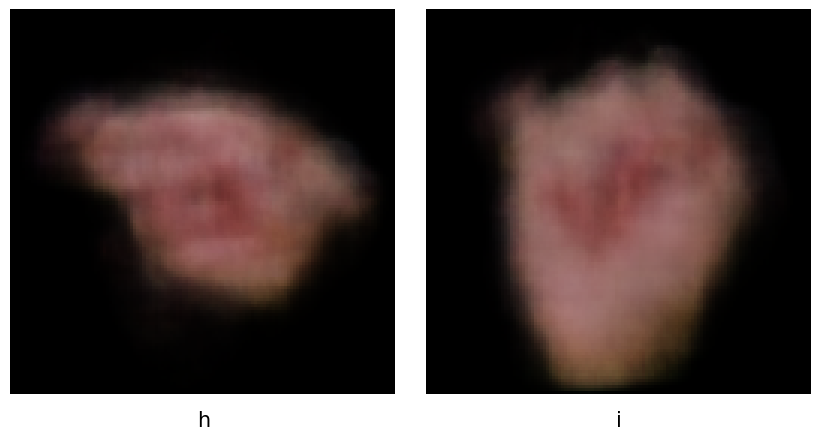

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


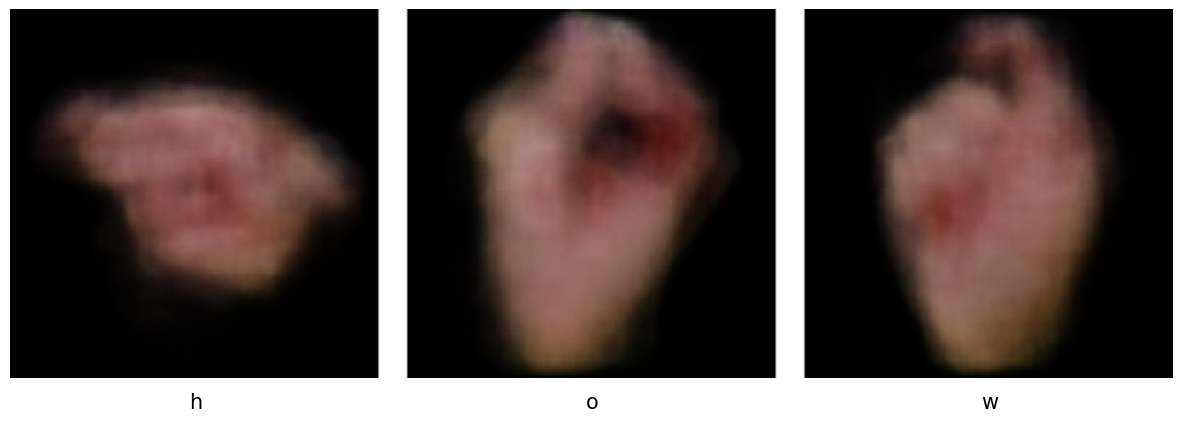

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


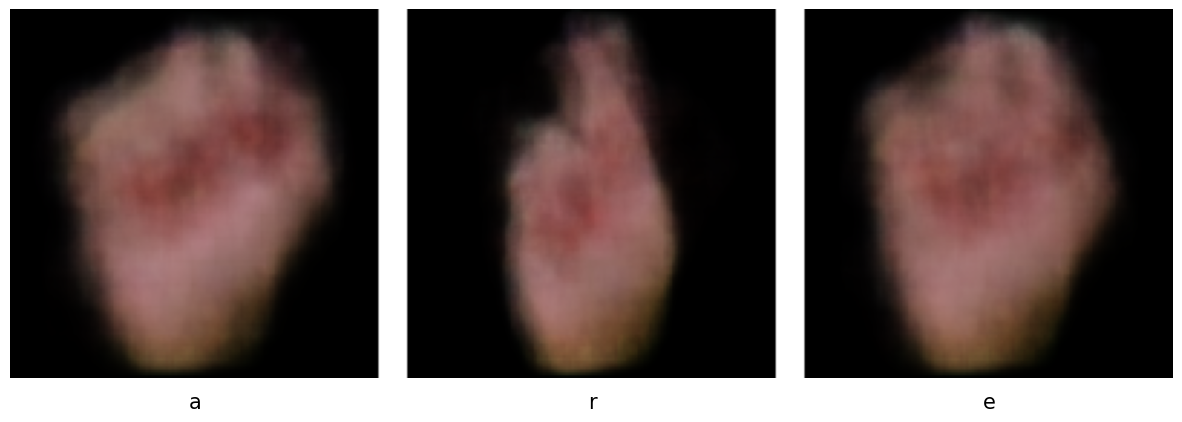

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


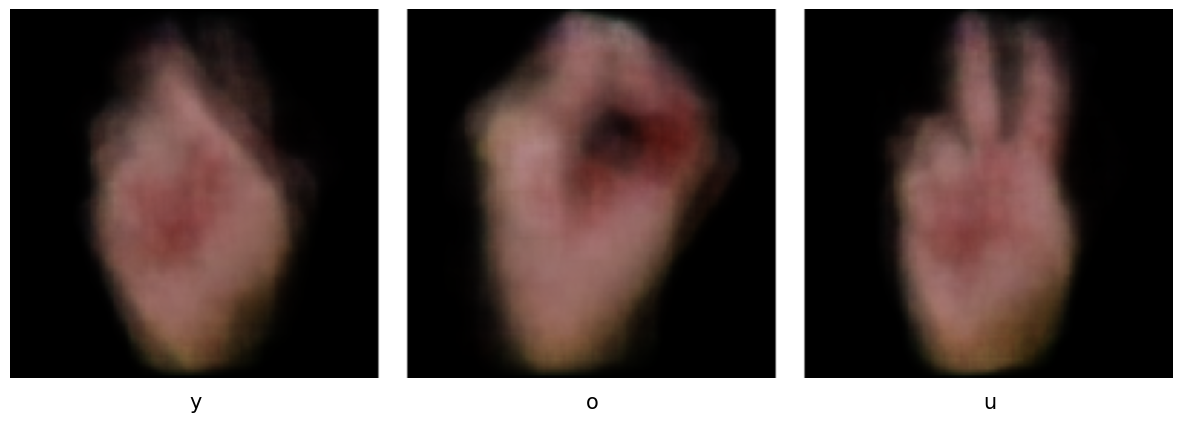

ValueError: too many values to unpack (expected 2)

: 

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Function to tokenize a sentence into letter sequences
def sentence_to_letter_sequences(sentence, tokenizer, max_label_length):
    letters = list(sentence.lower())
    sequences = tokenizer.texts_to_sequences([''.join(letters)])
    return pad_sequences(sequences, maxlen=max_label_length)

# Function to generate images from letter sequences
def generate_images_from_letters(model, letters, tokenizer, max_label_length):
    letter_sequences = tokenizer.texts_to_sequences(letters)
    letter_sequences = pad_sequences(letter_sequences, maxlen=max_label_length)
    
    images = []
    for i, seq in enumerate(letter_sequences):
        seq = np.expand_dims(seq, axis=0)  # Add batch dimension
        generated_image = model.predict(seq)
        generated_image = generated_image.squeeze()  # Remove batch dimension
        images.append((letters[i], generated_image))  # Include the letter label with the image
    return images

# Function to combine individual letter images into a single image
def combine_images(images, word_spacing=10):
    img_width = sum(img.shape[1] for _, img in images) + word_spacing * (len(images) - 1)
    img_height = max(img.shape[0] for _, img in images)
    
    combined_image = np.ones((img_height, img_width, 3))  # White background
    
    x_offset = 0
    for _, img in images:
        combined_image[:, x_offset:x_offset + img.shape[1]] = img
        x_offset += img.shape[1] + word_spacing
    
    return combined_image

# Function to label and display letter images in one line
def label_letter_images_in_line(images, word_spacing=10):
    fig, ax = plt.subplots(figsize=(15, 5))
    combined_image = combine_images(images, word_spacing)
    ax.imshow(combined_image)
    x_offset = 0
    for letter, img in images:
        ax.text(x_offset + img.shape[1] // 2, img.shape[0] + 10, letter, fontsize=15, ha='center')
        x_offset += img.shape[1] + word_spacing
    ax.axis('off')
    plt.show()

# Load the pre-trained model
model_path = r'C:\Users\Sejal\Desktop\FOSS\MODEL\smodel.keras'
model = tf.keras.models.load_model(model_path)

# Function to convert a sentence to a combined image representing sign language
def sentence_to_sign_language_images(model, sentence, tokenizer, max_label_length):
    words = sentence.split()
    sentence_images = []
    
    for word in words:
        letter_images = generate_images_from_letters(model, list(word), tokenizer, max_label_length)
        label_letter_images_in_line(letter_images)  # Display individual letter images with labels in one line
        word_image = combine_images(letter_images)
        sentence_images.append((word, word_image))  # Combine letters into a word
    
    return sentence_images

# Example usage
sentence = "hi how are you"
max_label_length = 5  # Define based on your model's requirements

# Initialize and fit the tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])

# Convert sentence to images
sentence_images = sentence_to_sign_language_images(model, sentence, tokenizer, max_label_length)

# Combine all word images into a single sentence blob and display it
sentence_combined_image = combine_images([img for _, img in sentence_images], word_spacing=30)

# Display the result
plt.imshow(sentence_combined_image)
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


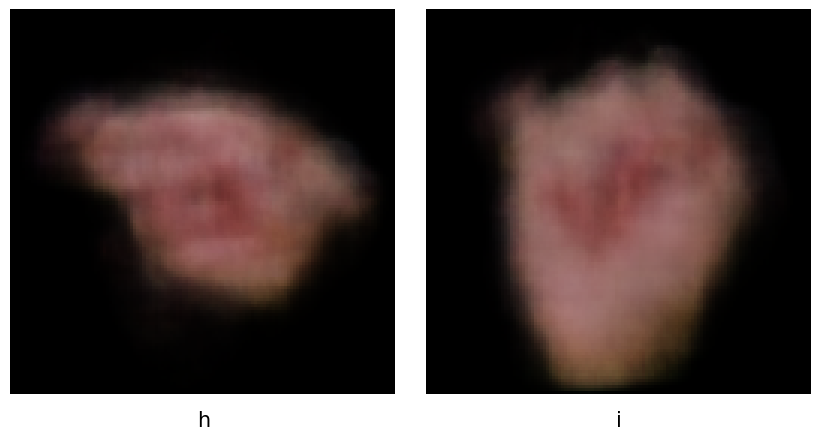

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


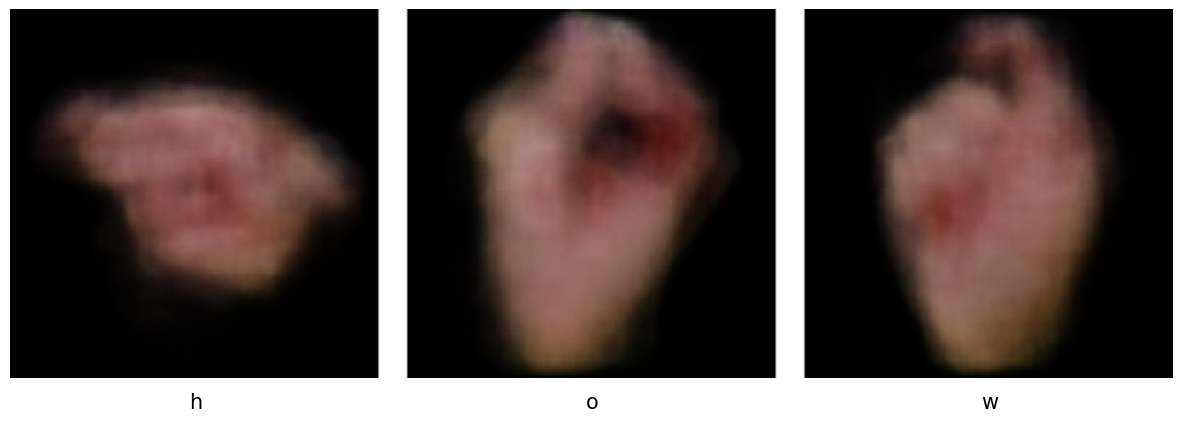

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


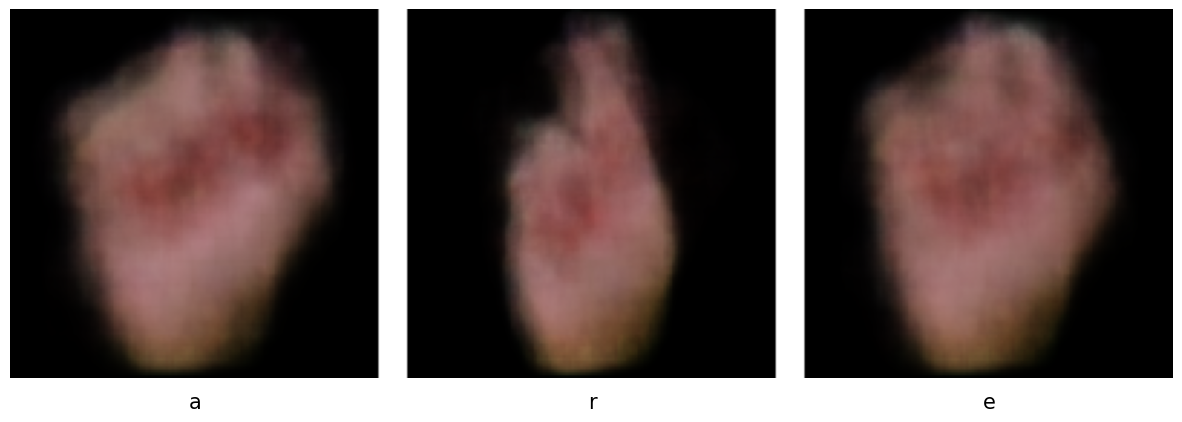

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


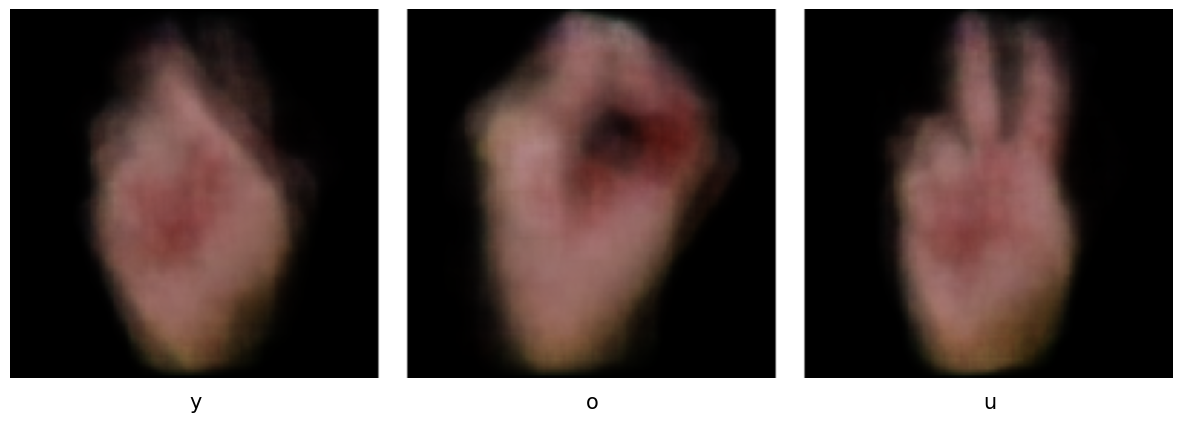

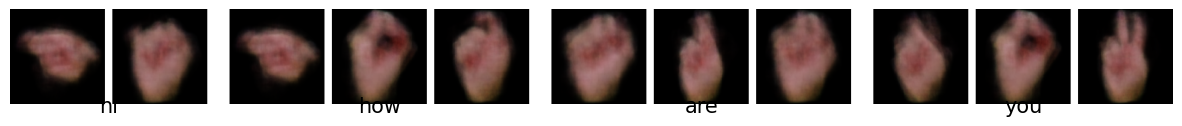

ValueError: too many values to unpack (expected 2)

In [30]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Function to tokenize a sentence into letter sequences
def sentence_to_letter_sequences(sentence, tokenizer, max_label_length):
    letters = list(sentence.lower())
    sequences = tokenizer.texts_to_sequences([''.join(letters)])
    return pad_sequences(sequences, maxlen=max_label_length)

# Function to generate images from letter sequences
def generate_images_from_letters(model, letters, tokenizer, max_label_length):
    letter_sequences = tokenizer.texts_to_sequences(letters)
    letter_sequences = pad_sequences(letter_sequences, maxlen=max_label_length)
    
    images = []
    for i, seq in enumerate(letter_sequences):
        seq = np.expand_dims(seq, axis=0)  # Add batch dimension
        generated_image = model.predict(seq)
        generated_image = generated_image.squeeze()  # Remove batch dimension
        images.append((letters[i], generated_image))  # Include the letter label with the image
    return images

# Function to combine individual letter images into a single image
def combine_images(images, word_spacing=10):
    img_width = sum(img.shape[1] for _, img in images) + word_spacing * (len(images) - 1)
    img_height = max(img.shape[0] for _, img in images)
    
    combined_image = np.ones((img_height, img_width, 3))  # White background
    
    x_offset = 0
    for _, img in images:
        combined_image[:, x_offset:x_offset + img.shape[1]] = img
        x_offset += img.shape[1] + word_spacing
    
    return combined_image

# Function to label and display letter images in one line
def label_letter_images_in_line(images, word_spacing=10):
    fig, ax = plt.subplots(figsize=(15, 5))
    combined_image = combine_images(images, word_spacing)
    ax.imshow(combined_image)
    x_offset = 0
    for letter, img in images:
        ax.text(x_offset + img.shape[1] // 2, img.shape[0] + 10, letter, fontsize=15, ha='center')
        x_offset += img.shape[1] + word_spacing
    ax.axis('off')
    plt.show()

# Load the pre-trained model
model_path = r'C:\Users\Sejal\Desktop\FOSS\MODEL\smodel.keras'
model = tf.keras.models.load_model(model_path)

# Function to convert a sentence to a combined image representing sign language
def sentence_to_sign_language_images(model, sentence, tokenizer, max_label_length):
    words = sentence.split()
    sentence_images = []
    
    for word in words:
        letter_images = generate_images_from_letters(model, list(word), tokenizer, max_label_length)
        label_letter_images_in_line(letter_images)  # Display individual letter images with labels in one line
        word_image = combine_images(letter_images)
        sentence_images.append((word, word_image))  # Combine letters into a word
    
    # Display combined word images in one line
    label_letter_images_in_line(sentence_images, word_spacing=30)
    
    return sentence_images

# Example usage
sentence = "hi how are you"
max_label_length = 5  # Define based on your model's requirements

# Initialize and fit the tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])

# Convert sentence to images
sentence_images = sentence_to_sign_language_images(model, sentence, tokenizer, max_label_length)

# Combine all word images into a single sentence blob and display it
sentence_combined_image = combine_images([img for _, img in sentence_images], word_spacing=30)

# Display the result
plt.imshow(sentence_combined_image)
plt.axis('off')
plt.show()
